# High dimensional nonlinear Poisson

We consider the nonlinear Poisson PDE
$$ -\nabla\cdot (a(u)\nabla u) = f(x), \quad x\in\Omega$$
$$ u(x) = g(x), \quad x\in\partial\Omega,$$
where $a(u)=u^3-u$ and $\Omega=[-1,1]^d$. The true solution is $u(x)=\exp(-\frac{1}{d}\sum_{i=1}^dx_i)$, and the function $f(x)$ is computed using the true solution $u(x)$.

In [203]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

import time

torch.set_default_dtype(torch.float64)

In [204]:
def sample_points(N_pts, d):
    """
    Generate training samples.
    """
    # interior points
    N_domain_tot = N_pts**2
    x_int = 2 * torch.rand(N_domain_tot, d, requires_grad=True) - 1
    
    # boundary
    x_bd = np.random.normal(-1,1,size=(4*N_pts,d))
    x_bd_norm = np.linalg.norm(x_bd, axis=1, ord=np.inf) 
    x_bd = x_bd / x_bd_norm.reshape((4*N_pts,1))
    x_bd = torch.from_numpy(x_bd)
    
    return x_int, x_bd

def u_true(x):
    """
    True function.
    """
    d = x.shape[1]
    return torch.exp( -x.sum(dim=1) / d )

def f(x):
    """
    Right-hand side.
    """
    d = x.shape[1]
    
    return (-3*u_true(x)**3 + 2*u_true(x)**2) / d

def g(x):
    """
    Boundary condition.
    """
    return u_true(x)

In [3]:
class RF_PDE(nn.Module):
    """
    Random Feature model.
    """
    def __init__(self, in_features, out_features, sigma=1.0):
        super(RF_PDE, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.sigma = sigma
        self.W = nn.Parameter(torch.randn(in_features, out_features) / sigma, requires_grad=False)
        self.b = nn.Parameter(torch.rand(out_features) * 2 * torch.pi, requires_grad=False)
        
        self.model = nn.Sequential(nn.Linear(out_features, 1))

        
    def forward(self, x):
        
        u = self.model(torch.cos(x @ self.W + self.b) * torch.sqrt( torch.tensor([2 / self.out_features])))
        return u
    
    
class PINN_PDE(nn.Module):
    """
    PINN model
    """
    def __init__(self, d):
        super(PINN_PDE, self).__init__()
        self.model = nn.Sequential(
        nn.Linear(d,64),
        nn.Tanh(),
        nn.Linear(64,64),
        nn.Tanh(),
        nn.Linear(64,1))
        
    def forward(self,x):
        u = self.model(x)
        return u
    
def loss_fn(model, x_in, x_bd, RHS, g):
    """
    Compute the loss
    """
    
    # interior:
    u = model(x_in)

    u_x = torch.autograd.grad(u, x_in, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_in, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        
    f = RHS(x_in)
    f = f.reshape(u.shape)
    
    residual = (1-2*u) * torch.sum(u_x ** 2, dim=1) + (u-u**2)*torch.sum(u_xx, dim=1) - f
    
    # boundary
    u_bd = model(x_bd)
    residual_bd = model(x_bd) - g(x_bd).reshape(u_bd.shape)

    return torch.mean(residual**2) + torch.Tensor([1e6]) * torch.mean(residual_bd**2)

def train(model, optimizer, x_in, x_bd, RHS, g, epochs=1000):
    
    losses = []
    for epoch in range(epochs):
        
        optimizer.zero_grad()
        loss = loss_fn(model, x_in, x_bd, RHS, g)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.item())
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")
    return losses

In [4]:
class ELM_PDE(nn.Module):
    """
    Extreme Learning Machine.
    """
    
    def __init__(self, in_features, out_features, R):
        super(ELM_PDE, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.R = R
        self.W = nn.Parameter(torch.rand(in_features, out_features) * 2 * R - R , requires_grad=False)
        
        self.model = nn.Sequential(nn.Linear(out_features, 1))
    
    def forward(self,x):
        
        # inputs = torch.cat((x,y), dim=1)
        u = self.model(torch.tanh(x @ self.W))
        return u

# Test with several dimensions

## d=2

In [5]:
# generate training samples
N_pts = 30
d = 2
x_int_train, x_bd_train = sample_points(N_pts,d)

# generate test samples
N_test = 500
x_test_int, x_test_bd = sample_points(N_test, d)
u_test_int = u_true(x_test_int).detach().numpy()
u_test_bd = u_true(x_test_bd).detach().numpy()

# initialize model and optimizer
N = 500
model_RF = RF_PDE(d, N, sigma = 1)
optimizer = optim.Adam(model_RF.parameters(), lr=1e-2, weight_decay=0.000001)

# Train the model
start = time.time()
losses = train(model_RF, optimizer, x_int_train, x_bd_train, f, g, epochs=1000)
end = time.time()
print(f'Computational time is {end-start:.2f}')

Epoch 0, Loss: 3856598.5708879107
Computational time is 41.70


In [6]:
# compute predictions and test errors
RF_pred_int = model_RF(x_test_int).detach().numpy()
RF_pred_bd = model_RF(x_test_bd).detach().numpy()

err_int = np.sum( (u_test_int.reshape(RF_pred_int.shape) - RF_pred_int ) ** 2 )
err_bd = np.sum( (u_test_bd.reshape(RF_pred_bd.shape) - RF_pred_bd) ** 2 )
err_RF = (err_int + err_bd) / (np.size(RF_pred_int) + np.size(RF_pred_bd) )
print(f'Test error of RF is {err_RF:.2e}')

Test error of RF is 8.13e-03


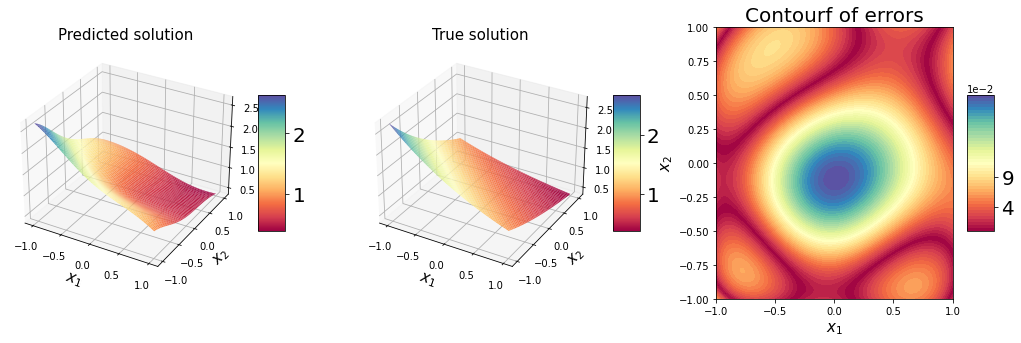

In [7]:
## visualization
num_pts = 100
xx= np.linspace(-1, 1, num_pts)
yy = np.linspace(-1, 1, num_pts)
XX, YY = np.meshgrid(xx, yy)

XX_test, YY_test = XX.reshape(num_pts**2,1), YY.reshape(num_pts**2,1)
XX_test, YY_test = torch.from_numpy(XX_test), torch.from_numpy(YY_test)

XX, YY = torch.from_numpy(XX), torch.from_numpy(YY)

X_test = torch.concat( (XX_test,YY_test), dim=1)

u_truth = u_true(X_test)

# plot the true solution
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(132, projection='3d')
u_truth_surf=ax.plot_surface(XX, YY, u_truth.reshape(num_pts,num_pts), cmap='Spectral')
plt.xlabel(r'$x_1$', size=15) 
plt.ylabel(r'$x_2$',size=15) 
plt.title('True solution', size=15)
cbar = fig.colorbar(u_truth_surf, shrink= 0.5, aspect = 5)
cbar.ax.tick_params(labelsize=20)

# plot the test solution
u_test = model_RF(X_test)
u_test = u_test.detach().numpy()
u_test = u_test.reshape(num_pts,num_pts)
ax = fig.add_subplot(131, projection='3d')
u_test_surf=ax.plot_surface(XX, YY, u_test, cmap='Spectral')
plt.xlabel(r'$x_1$', size=15) 
plt.ylabel(r'$x_2$',size=15) 
plt.title('Predicted solution',size=15)
cbar = fig.colorbar(u_test_surf, shrink= 0.5, aspect = 5)
cbar.ax.tick_params(labelsize=20)

# plot error
ax = fig.add_subplot(133)
u_contourf=ax.contourf(XX, YY, abs(u_truth.reshape(num_pts,num_pts)-u_test), 50, cmap='Spectral')
plt.xlabel(r'$x_1$', size=15) 
plt.ylabel(r'$x_2$',size=15)  
plt.title('Contourf of errors', size=20)
cbar = fig.colorbar(u_contourf, shrink= 0.5, aspect = 5, ticks=[0.04,0.09])
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.tick_params(labelsize=20)
plt.savefig('Poisson.pdf', bbox_inches = 'tight')

In [8]:
# initialize model and optimizer
model = PINN_PDE(d)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
# Train the model
start = time.time()
losses = train(model, optimizer, x_int_train, x_bd_train, f, g, epochs=2000)
end = time.time()
print(f'Computational time is {end-start:.2f}')

# compute test error 
PINN_pred_int = model(x_test_int).detach().numpy()
PINN_pred_bd = model(x_test_bd).detach().numpy()

# 
err_PINN_int = np.sum( (u_test_int.reshape(PINN_pred_int.shape) - PINN_pred_int ) ** 2 )
err_PINN_bd = np.sum( (u_test_bd.reshape(PINN_pred_bd.shape) - PINN_pred_bd) ** 2 )
err_PINN = (err_PINN_int + err_PINN_bd) / (np.size(PINN_pred_int) + np.size(PINN_pred_bd) )
print(f'Test error of PINN is {err_PINN:.2e}')

Epoch 0, Loss: 2899109.0791356326
Epoch 1000, Loss: 19.556350890015263
Computational time is 54.19
Test error of PINN is 4.22e-03


In [9]:
################### ELM
# initialize ELM model and optimizer
model_ELM = ELM_PDE(d, N, R = 0.05)
optimizer = optim.Adam(model_ELM.parameters(), lr=1e-2)


# Train the model
start = time.time()
losses = train(model_ELM, optimizer, x_int_train, x_bd_train, f, g, epochs=1000)
end = time.time()
print(f'Computational time is {end-start:.2f} seconds')


# compute test error 
ELM_pred_int = model_ELM(x_test_int).detach().numpy()
ELM_pred_bd = model_ELM(x_test_bd).detach().numpy()

# 
err_ELM_int = np.sum( (u_test_int.reshape(ELM_pred_int.shape) - ELM_pred_int ) ** 2 )
err_ELM_bd = np.sum( (u_test_bd.reshape(ELM_pred_bd.shape) - ELM_pred_bd) ** 2 )
err_ELM = (err_ELM_int + err_ELM_bd) / (np.size(ELM_pred_int) + np.size(ELM_pred_bd) )
print(f'Test error of ELM is {err_ELM:.2e}')

Epoch 0, Loss: 3661539.14024885
Computational time is 30.46 seconds
Test error of ELM is 2.37e-02


## d=4

In [10]:
################ d=4
# generate training samples
N_pts = 30
d = 4
x_int_train, x_bd_train = sample_points(N_pts,d)

# generate test samples
N_test = 50
x_test_int, x_test_bd = sample_points(N_test, d)
u_test_int = u_true(x_test_int).detach().numpy()
u_test_bd = u_true(x_test_bd).detach().numpy()

##################### RF
# initialize model and optimizer
N = 500
model_RF = RF_PDE(d, N, sigma = 3)
optimizer = optim.Adam(model_RF.parameters(), lr=1e-2, weight_decay=0.000001)

# Train RF model
start = time.time()
losses = train(model_RF, optimizer, x_int_train, x_bd_train, f, g, epochs=1000)
end = time.time()
print(f'Computational time of RF is {end-start:.2f}')

# compute predictions and test errors
RF_pred_int = model_RF(x_test_int).detach().numpy()
RF_pred_bd = model_RF(x_test_bd).detach().numpy()

err_RF_int = np.sum( (u_test_int.reshape(RF_pred_int.shape) - RF_pred_int ) ** 2 )
err_RF_bd = np.sum( (u_test_bd.reshape(RF_pred_bd.shape) - RF_pred_bd) ** 2 )
err_RF = (err_RF_int + err_RF_bd) / (np.size(RF_pred_int) + np.size(RF_pred_bd) )
print(f'Test error of RF is {err_RF:.2e}')

Epoch 0, Loss: 2923078.579439061
Computational time of RF is 35.66
Test error of RF is 2.34e-02


In [11]:
# initialize model and optimizer
model_PINN = PINN_PDE(d)
optimizer = optim.Adam(model_PINN.parameters(), lr=1e-2)
# Train the model
start = time.time()
losses = train(model_PINN, optimizer, x_int_train, x_bd_train, f, g, epochs=2000)
end = time.time()
print(f'Computational time is {end-start:.2f}')

# compute test error 
PINN_pred_int = model_PINN(x_test_int).detach().numpy()
PINN_pred_bd = model_PINN(x_test_bd).detach().numpy()

# 
err_PINN_int = np.sum( (u_test_int.reshape(PINN_pred_int.shape) - PINN_pred_int ) ** 2 )
err_PINN_bd = np.sum( (u_test_bd.reshape(PINN_pred_bd.shape) - PINN_pred_bd) ** 2 )
err_PINN = (err_PINN_int + err_PINN_bd) / (np.size(PINN_pred_int) + np.size(PINN_pred_bd) )
print(f'Test error of PINN is {err_PINN:.2e}')

Epoch 0, Loss: 2848958.9745286186
Epoch 1000, Loss: 13.627134441882623
Computational time is 48.66
Test error of PINN is 5.12e-03


In [12]:
################### ELM
# initialize ELM model and optimizer
model_ELM = ELM_PDE(d, N, R = 0.05)
optimizer = optim.Adam(model_ELM.parameters(), lr=1e-2)


# Train the model
start = time.time()
losses = train(model_ELM, optimizer, x_int_train, x_bd_train, f, g, epochs=1000)
end = time.time()
print(f'Computational time is {end-start:.2f} seconds')


# compute test error 
ELM_pred_int = model_ELM(x_test_int).detach().numpy()
ELM_pred_bd = model_ELM(x_test_bd).detach().numpy()

# 
err_ELM_int = np.sum( (u_test_int.reshape(ELM_pred_int.shape) - ELM_pred_int ) ** 2 )
err_ELM_bd = np.sum( (u_test_bd.reshape(ELM_pred_bd.shape) - ELM_pred_bd) ** 2 )
err_ELM = (err_ELM_int + err_ELM_bd) / (np.size(ELM_pred_int) + np.size(ELM_pred_bd) )
print(f'Test error of ELM is {err_ELM:.2e}')

Epoch 0, Loss: 2699542.468807038
Computational time is 32.17 seconds
Test error of ELM is 5.62e-02


## d=8

In [45]:
# generate training samples
N_pts = 30
d = 8
x_int_train, x_bd_train = sample_points(N_pts,d)

# generate test samples
N_test = 50
x_test_int, x_test_bd = sample_points(N_test, d)
u_test_int = u_true(x_test_int).detach().numpy()
u_test_bd = u_true(x_test_bd).detach().numpy()

##################### RF
# initialize model and optimizer
N = 100
model_RF = RF_PDE(d, N, sigma = 3)
optimizer = optim.Adam(model_RF.parameters(), lr=1e-2, weight_decay=0.000001)

# Train RF model
start = time.time()
losses = train(model_RF, optimizer, x_int_train, x_bd_train, f, g, epochs=1500)
end = time.time()
print(f'Computational time of RF is {end-start:.2f}')

# compute predictions and test errors
RF_pred_int = model_RF(x_test_int).detach().numpy()
RF_pred_bd = model_RF(x_test_bd).detach().numpy()

err_RF_int = np.sum( (u_test_int.reshape(RF_pred_int.shape) - RF_pred_int ) ** 2 )
err_RF_bd = np.sum( (u_test_bd.reshape(RF_pred_bd.shape) - RF_pred_bd) ** 2 )
err_RF = (err_RF_int + err_RF_bd) / (np.size(RF_pred_int) + np.size(RF_pred_bd) )
print(f'Test error of RF is {err_RF:.2e}')


Epoch 0, Loss: 2546075.725902421
Epoch 1000, Loss: 1822.589134728664
Computational time of RF is 37.25
Test error of RF is 2.35e-02


In [14]:
##################### PINN
# initialize model and optimizer
model_PINN = PINN_PDE(d)
optimizer = optim.Adam(model_PINN.parameters(), lr=1e-2)
# Train the model
start = time.time()
losses = train(model_PINN, optimizer, x_int_train, x_bd_train, f, g, epochs=2000)
end = time.time()
print(f'Computational time of PINN is {end-start:.2f}')

# compute test error 
PINN_pred_int = model_PINN(x_test_int).detach().numpy()
PINN_pred_bd = model_PINN(x_test_bd).detach().numpy()

# 
err_PINN_int = np.sum( (u_test_int.reshape(PINN_pred_int.shape) - PINN_pred_int ) ** 2 )
err_PINN_bd = np.sum( (u_test_bd.reshape(PINN_pred_bd.shape) - PINN_pred_bd) ** 2 )
err_PINN = (err_PINN_int + err_PINN_bd) / (np.size(PINN_pred_int) + np.size(PINN_pred_bd) )
print(f'Test error of PINN is {err_PINN:.2e}')

Epoch 0, Loss: 2041616.1780238058
Epoch 1000, Loss: 57.37310813824446
Computational time of PINN is 57.87
Test error of PINN is 4.32e-03


In [15]:
################### ELM
# initialize ELM model and optimizer
model_ELM = ELM_PDE(d, N, R = 0.05)
optimizer = optim.Adam(model_ELM.parameters(), lr=1e-2)


# Train the model
start = time.time()
losses = train(model_ELM, optimizer, x_int_train, x_bd_train, f, g, epochs=1000)
end = time.time()
print(f'Computational time is {end-start:.2f} seconds')


# compute test error 
ELM_pred_int = model_ELM(x_test_int).detach().numpy()
ELM_pred_bd = model_ELM(x_test_bd).detach().numpy()

# 
err_ELM_int = np.sum( (u_test_int.reshape(ELM_pred_int.shape) - ELM_pred_int ) ** 2 )
err_ELM_bd = np.sum( (u_test_bd.reshape(ELM_pred_bd.shape) - ELM_pred_bd) ** 2 )
err_ELM = (err_ELM_int + err_ELM_bd) / (np.size(ELM_pred_int) + np.size(ELM_pred_bd) )
print(f'Test error of ELM is {err_ELM:.2e}')

Epoch 0, Loss: 2563969.706005053
Computational time is 31.01 seconds
Test error of ELM is 3.86e-02


## NLS

In [237]:
def Jacobian(c):
    
    u = A_int@c
    
    m = A_int.shape[0]
    A1 = np.zeros(m)
    for i in range(m):
        A1[i] = np.sum( (( (1 - A_int[i]**2) * W) @ c) ** 2 )
    
    ################ G(c)
    value1 = (1-2*u) * A1 + (u-u**2) * (delta_u @ c) - rhs_pde.detach().numpy().reshape(-1)
    value2 = A_bd @ c - rhs_bd.detach().numpy().reshape(-1)
    # concatenate
    rhs = np.concatenate((value1, value2))
    
    ################ Compute Jacobian
    u = u.reshape((u.shape[0],1))
    B = np.zeros(A_int.shape)
    for i in range(m):
        u_x = ( (1 - A_int[i]**2) * W) @ c
        u_x = u_x.reshape((u_x.shape[0],1))
        B[i] = np.sum(u_x * W, axis=0)
        
    A2 = (delta_u @ c)
    A2 = A2.reshape((A2.shape[0],1))
    # Jacobian 1
    J1 = -2 * A_int * A1.reshape((m,1)) + (1-2*u) * 2 * (1 - A_int**2) * B + (A_int - 2 * u * A_int) * A2 + (u - u**2) * delta_u 
    J = np.row_stack((J1,A_bd))
    
    return J, rhs    

In [238]:
# generate training samples
N_pts = 30
d = 4
x_int_train, x_bd_train = sample_points(N_pts,d)

# generate test samples
N_test = 50
x_test_int, x_test_bd = sample_points(N_test, d)
u_test_int = u_true(x_test_int).detach().numpy()
u_test_bd = u_true(x_test_bd).detach().numpy()



# compute rhs
rhs_pde = f(x_int_train)
rhs_bd = g(x_bd_train)


# generate weights
N = 500                               # number of random features
R = 2
W = np.random.uniform(-R,R, size=(d,N))
W_sum = np.sum(W,axis=0)
W_norm = np.linalg.norm(W,axis=0) ** 2

x_train = x_int_train.detach().numpy()
A_int = np.tanh(x_train @ W)

x_bd = x_bd_train.detach().numpy()
A_bd = np.tanh(x_bd @ W)

# test points
x_test_int = x_test_int.detach().numpy()
A_test_int = np.tanh(x_test_int @ W)

x_test_bd = x_test_bd.detach().numpy()
A_test_bd = np.tanh(x_test_bd @ W)


# some matrices
delta_u = - 2 * A_int * (1-A_int**2) * W_norm


# Initial guess for parameters
#c = np.zeros((N,))
c = np.random.rand(N)
# Iter 100 times
Iter = 50
# test error
test_err = []
start = time.time()
for i in range(Iter):
    
    J, rhs = Jacobian(c)
    
    delta_c = np.linalg.pinv(J) @ (-rhs)
    c = c + delta_c
    
    # compute errors:
    pred_int = A_test_int @ c
    err_int = np.sum( (u_test_int.reshape(pred_int.shape) - pred_int)**2 )
    
    pred_bd = A_test_bd @ c
    err_bd = np.sum( (u_test_bd.reshape(pred_bd.shape) - pred_bd)**2 )

    err_ELM = (err_int + err_bd) / (np.size(pred_int) + np.size(pred_bd))
    test_err.append(err_ELM)
end = time.time()

print(f'Test error of RF model is {min(test_err):.2e}')
print(f'Training time is {end-start:.2f} seconds')

Test error of RF model is 1.12e+00
Training time is 5.88 seconds


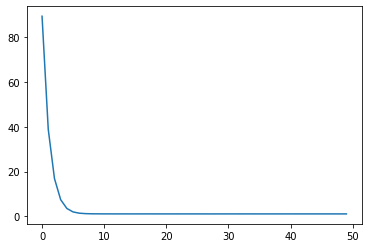

In [239]:
plt.plot(test_err)

In [240]:
# def Jacobian

def Jacobian(c):
    
    u = A_int@c
    
    m = A_int.shape[0]
    A1 = np.zeros(m)
    for i in range(m):
        A1[i] = - np.sum(  ( (A_sin[i] * W) @ c) ** 2 )
    
    ################ G(c)
    value1 = (1-2*u) * A1 + (u-u**2) * (delta_u @ c) - rhs_pde.detach().numpy().reshape(-1)
    value2 = A_bd @ c - rhs_bd.detach().numpy().reshape(-1)
    # concatenate
    rhs = np.concatenate((value1, value2))
    
    ################ Compute Jacobian
    u = u.reshape((u.shape[0],1))
    B = np.zeros(A_int.shape)
    for i in range(m):
        u_x = ( A_sin[i] * W) @ c
        u_x = u_x.reshape((u_x.shape[0],1))
        B[i] = np.sum(u_x * W, axis=0)
        
    A2 = (delta_u @ c)
    A2 = A2.reshape((A2.shape[0],1))
    # Jacobian 1
    J1 = -2 * A_int * A1.reshape((m,1)) - (1-2*u) * 2 * A_sin * B + (A_int - 2 * u * A_int) * A2 + (u - u**2) * delta_u 
    J = np.row_stack((J1,A_bd))
    
    return J, rhs    

In [243]:
# RF

## RF model trained by non-linear least square
N = 1000
sigma = 10

# random features
W = np.random.randn(d,N) / sigma
W_sum = np.sum(W,axis=0)
W_norm = np.linalg.norm(W,axis=0) ** 2

b = np.random.uniform(0, 2*np.pi, N)

# matrix A
A_int = np.cos(x_train @ W + b)
A_sin = np.sin(x_train @ W + b)
A_bd = np.cos(x_bd @ W + b)
A_test_int = np.cos(x_test_int @ W + b)
A_test_bd = np.cos(x_test_bd @ W + b)

# some matrices
delta_u = - A_int * W_norm

# Initial guess for parameters
c = np.zeros((N,))
#c = np.random.rand(N)
# Iter 100 times
Iter = 30
# test error
test_err = []
start = time.time()
for i in range(Iter):
    
    J, rhs = Jacobian(c)
    
    delta_c = np.linalg.pinv(J) @ (-rhs)
    c = c + delta_c

    # compute errors:
    pred_int = A_test_int @ c
    err_int = np.sum( (u_test_int.reshape(pred_int.shape) - pred_int)**2 )
    
    pred_bd = A_test_bd @ c
    err_bd = np.sum( (u_test_bd.reshape(pred_bd.shape) - pred_bd)**2 )

    err_ELM = (err_int + err_bd) / (np.size(pred_int) + np.size(pred_bd))
    test_err.append(err_ELM)
end = time.time()
print(f'Test error of RF model is {min(test_err):.2e}')
print(f'Training time is {end-start:.2f} seconds')

Test error of RF model is 1.92e-04
Training time is 7.11 seconds
